<a href="https://colab.research.google.com/github/stephenadhi/nn-mpc/blob/main/prediction_testing/tenstepahead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
sys.executable
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
from pandas import DataFrame
from pandas import read_csv
import math
from numpy import savetxt
from keras import layers
from tensorflow.keras.layers import Input, LSTM, Dense, Reshape, Dropout
from tensorflow.keras.models import Model, Sequential
from scipy.integrate import odeint, RK45
from tensorflow.keras.utils import plot_model
import timeit
from functools import partial
tf.keras.backend.set_floatx('float64')
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

## Mass-Spring-System

In [3]:
#This system is undamped

# Use ODEINT to solve the differential equations defined by the vector field
from scipy.integrate import odeint

def vectorfield(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x1,y1,x2,y2]
        t :  time
        p :  vector of the parameters:
                  p = [m1,m2,k1,k2,L1,L2,b1,b2]
    """
    x1, v1, x2, v2, x3, v3 = w
    m, k, kp, u1, u2, dist = p

    # Create f = (x1',y1',x2',y2'):
    f = [v1,
         (k * ((-2 * x1) + x2) + kp * (-x1 ** 3 + (x2 - x1) ** 3)) / m + u1,
         v2,
         (k * (x1 - (2 * x2) + x3) + kp * ((x3 - x2) ** 3 - (x2 - x1) ** 3)) / m + u2,
         v3,
         (k * (x2 - x3) + kp * ((x2 - x3) ** 3)) / m + dist]
    return f

## **Training Data Generation**

In [5]:
num_rollouts= 1
# Masses:
m = 0.5 
# Spring constants
kp = 63.5
k = 217.0
# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6

num_data= 20003
interval= 0.001
stoptime = interval*(num_data)
np.random.seed(0)
hist= np.zeros((1,15))

for roll in range(1):
    act1= 2000*(np.random.rand(num_data)-0.5)
    act2= 2000*(np.random.rand(num_data)-0.5)
    dist = 1000*(np.random.rand(num_data)-0.5)
    #Initial states
    w0= np.zeros((1,6))
    #w0 = np.random.randn(1,6) 
    w0= w0.flatten()
    prev = [[w0[0],w0[2],w0[4]]]
    # Pack up the parameters and initial conditions:
    p = [m, k, kp, act1[0], act2[0], dist[0]]
    # Call the ODE solver.
    t1= np.array([0,interval])
    wsol1 = odeint(vectorfield, w0, t1, args=(p,),
            atol=abserr, rtol=relerr)
    wsol1 = wsol1.flatten()
    wcurr = np.array([wsol1[6:]])
    w0=wsol1[6:]
    prevv= prev
    prev = [[w0[0],w0[2],w0[4]]]
    # Pack up the parameters and initial conditions:
    p = [m, k, kp, act1[1], dist[1], act2[1]]
    # Call the ODE solver.
    t2= np.array([0+interval,interval+interval])
    wsol1 = odeint(vectorfield, w0, t2, args=(p,),
            atol=abserr, rtol=relerr)
    wsol1 = wsol1.flatten()
    wcurr = np.array([wsol1[6:]])
    w0=wsol1[6:]
    curr = np.hstack((prevv, prev, np.array([[act1[1]]]),np.array([[dist[1]]]),np.array([[act2[1]]]),wcurr))
    hist= np.vstack((hist, curr))
   
    lag=2
    for ts in range(num_data-lag):
        prevv = prev
        t = np.array([stoptime * float(ts+lag) / (num_data), stoptime * float(ts + lag + 1) / (num_data)])
        p = [m, k, kp, act1[ts+lag],  dist[ts+lag], act2[ts+lag]]
        # Call the ODE solver.
        wsol1 = odeint(vectorfield, w0, t, args=(p,),
            atol=abserr, rtol=relerr)
        wsol1 = wsol1.flatten()
        w0 = wsol1[6:]
        prev = np.array([[wsol1[0],wsol1[2],wsol1[4]]])
        action= [act1[ts+lag],act2[ts+lag]]
        new = np.hstack((prevv,prev,np.array([[act1[ts+lag]]]),np.array([[dist[ts+lag]]]),np.array([[act2[ts+lag]]]),np.array([w0])))
        hist = np.vstack((hist, new))


In [6]:
#create table
hist=pd.DataFrame(data=hist,columns =["prev11", "prev22","prev33","prev1","prev2","prev3","u1","dist.","u2","x1", "v1", "x2", "v2", "x3", "v3"])
df=hist[1:][{"u1","dist.","u2","prev11","prev22","prev33","prev1","prev2","prev3","x1", "v1", "x2", "v2", "x3", "v3"}]
df = df[['u1','dist.','u2',"prev11","prev22","prev33","prev1","prev2","prev3",'x1','v1','x2','v2','x3','v3']]

NN_in= df[{"u1","u2","dist."}]
NN_in= NN_in[['u1','dist.','u2']].shift(-1)
NN_label= df[{"x1", "x3"}]
NN_label= NN_label[ ["x1", "x3"] ]
NN_previous= df[{"prev11","prev33","prev1","prev3"}]
NN_previous= NN_previous[ ["prev11","prev33"] ]
diff1= df["x1"] - df["prev1"]
diff3= df["x3"] - df["prev3"]
diff21= df["x1"] - df["prev11"]
diff23= df["x3"] - df["prev33"]
df.insert(7, "diff21", diff21)
df.insert(8, "diff23", diff23)
df.insert(9, "diff1", diff1)
df.insert(10, "diff3", diff3)
bothdiff= df[["diff1","diff3"]].shift(0)
bothdiff2= df[["diff21","diff23"]].shift(0)
frames = [NN_in,bothdiff2, NN_label, NN_previous, bothdiff]
df = pd.concat(frames, axis=1)
#x1_ = df[{'x1'}]
#x3_ = df[{'x3'}]
#prev111 = x1_.shift(3)
#prev333 = x3_.shift(3)
#prev1111 = x1_.shift(4)
#prev3333 = x3_.shift(4)
#df.insert(3,"prev1111",prev1111)
#df.insert(4,"prev3333",prev3333)
#df.insert(3,"prev111",prev111)
#df.insert(4,"prev333",prev333)
#diff31= df["x1"] - df["prev111"]
#diff33= df["x3"] - df["prev333"]
#df=df.drop(columns=["prev111","prev333"])
#df.insert(3, "diff31", diff31)
#df.insert(4, "diff33", diff33)
af=df.dropna()


In [7]:
#df= af[ ["u1","dist.","u2", "x1", "x3","diff21","diff23","diff1","diff3"] ]
df= af[ ["u1","dist.","u2", "x1", "x3","diff21","diff23","diff1","diff3"] ]

#df.to_csv('u1500newage20000_0.001ssim.csv',index=False)
df

,u1,dist.,u2,x1,x3,diff21,diff23,diff1,diff3
1,205.526752,399.234052,445.448979,0.000362,0.000261,0.000362,0.000261,0.000313,0.000322
2,89.766366,-327.561206,836.639904,0.000992,0.001250,0.000943,0.001311,0.000630,0.000989
3,-152.690401,86.060633,646.535077,0.001768,0.002878,0.001407,0.002618,0.000777,0.001629
4,291.788226,-470.680398,293.793404,0.002511,0.005247,0.001520,0.003998,0.000743,0.002369
5,-124.825577,-278.836089,-864.121960,0.003322,0.008083,0.001553,0.005205,0.000810,0.002836
...,...,...,...,...,...,...,...,...,...
19997,-279.746772,83.200125,-577.347993,1.964127,-0.122329,0.086241,0.147579,0.042006,0.074539
19998,251.773292,452.330307,-46.190463,2.003918,-0.046942,0.081798,0.149926,0.039792,0.075387
19999,-215.654077,-219.211301,-835.531287,2.041629,0.029440,0.077502,0.151769,0.037711,0.076382
20000,-917.686828,295.345317,-524.681269,2.077246,0.106724,0.073328,0.153665,0.035617,0.077284


In [8]:
#max(df[{'diff1'}].values)
#plot_cols = ['u1','dist.','u2']
#plot_features = df[plot_cols][1:100]
#_ = plot_features.plot(subplots=True)
#plot_states = ['x1', 'v1', 'x2', 'v2', 'x3', 'v3']
#plot_states = ['x1', 'x3']
#plot_features = df[plot_states][:]
#_ = plot_features.plot(subplots=True)
#plot_out= ['x1','x3']
#plot_features = df[plot_out][1:100]
#_ = plot_features.plot(subplots=True)

In [ ]:
train_df = pd.read_csv('u1500newage20000_0.001ssim.csv')
#val_df = df[int(0.5*n):int(1*n)]
val_df= pd.read_csv('u1500validationdatanewage5k_0.001ssim.csv')
test_df = pd.read_csv('u1500validationdatanewage5k_0.001ssim.csv')

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()
train_mean

u1       -12.512711
dist.     -0.479247
u2        -1.867312
x1         0.014431
x3         0.038057
diff21     0.000301
diff23     0.000105
diff1      0.000150
diff3      0.000054
dtype: float64

In [ ]:
batchsize= 32

## Data Processing Functions

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, 
               #test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, plot_col, model=None, max_subplots=1):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Timestep ')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float64)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=batchsize,)
  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

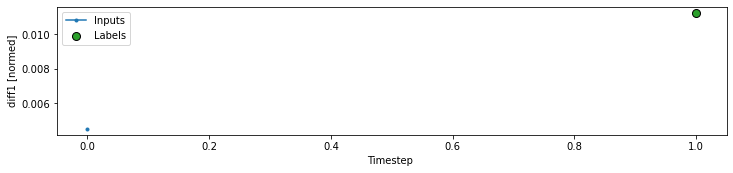

In [ ]:
OUT_STEPS = 1
multi_window = WindowGenerator(input_width=1,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                              label_columns= ['diff1','diff3']
                              )

multi_window.plot('diff1')

In [ ]:
multi_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['diff1', 'diff3']

In [ ]:
for example_inputs, example_labels in multi_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 2)


In [ ]:
multi_window.train

<MapDataset shapes: ((None, 1, 9), (None, 1, 2)), types: (tf.float64, tf.float64)>

## Define NN Model

In [ ]:
MAX_EPOCHS = 100
def compile(model, lr=0.001):
      model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=lr),
                metrics=[tf.metrics.MeanSquaredError()],
                   experimental_steps_per_execution=10

                    )
        
def scheduler(epoch, lr):
    if epoch > 100:
        return lr * tf.math.exp(-0.01)
    else: return lr

def fit(model, window, patience=150):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping,
                   #  callback
                                ]
                     )
  return history

multi_val_performance = {}
multi_performance = {}
num_label=2

In [ ]:
multi_window.train

<MapDataset shapes: ((None, 1, 9), (None, 1, 2)), types: (tf.float64, tf.float64)>

In [ ]:
from matplotlib import patches
def plotting(history):
    plt.semilogy(history.history['loss'], color = "red")
    plt.semilogy(history.history['val_loss'], color = "blue")
    red_patch = patches.Patch(color='red', label='Training')
    blue_patch = patches.Patch(color='blue', label='Validation')
    plt.legend(handles=[red_patch, blue_patch])
    plt.xlabel('Epochs')
    plt.ylabel('MSE loss')

In [ ]:
from functools import partial
multi_resdense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
  tf.keras.layers.Dense(10, activation=partial(tf.nn.leaky_relu, alpha=0.5)),
    tf.keras.layers.Dense(OUT_STEPS*num_label,
                         kernel_initializer=tf.initializers.zeros
                         ),
])
compile(multi_resdense_model,lr=0.001)


## Traning with different hyperparameters 

In [ ]:
tf.keras.backend.clear_session()
start_time = timeit.default_timer()
history = fit(multi_resdense_model, multi_window)

elapsed = timeit.default_timer() - start_time 
print(elapsed / 200)

Epoch 1/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0727 - mean_squared_error: 0.0727 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 2/100
625/625 [==============================] - 1s 1ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 3/100
625/625 [==============================] - 1s 1ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 4/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 9.1158e-04 - val_mean_squared_error: 9.1158e-04
Epoch 5/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 7.5314e-04 - val_mean_squared_error: 7.5314e-04
Epoch 6/100
625/625 [==============================] - 1s 1ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 6.2782e-04 - val_mean_squared_error: 6.2782e-0

625/625 [==============================] - 1s 2ms/step - loss: 3.3474e-04 - mean_squared_error: 3.3474e-04 - val_loss: 1.4928e-04 - val_mean_squared_error: 1.4928e-04
Epoch 94/100
625/625 [==============================] - 1s 2ms/step - loss: 3.2761e-04 - mean_squared_error: 3.2761e-04 - val_loss: 1.5012e-04 - val_mean_squared_error: 1.5012e-04
Epoch 95/100
625/625 [==============================] - 1s 2ms/step - loss: 3.2118e-04 - mean_squared_error: 3.2118e-04 - val_loss: 1.5091e-04 - val_mean_squared_error: 1.5091e-04
Epoch 96/100
625/625 [==============================] - 1s 2ms/step - loss: 3.1509e-04 - mean_squared_error: 3.1509e-04 - val_loss: 1.5097e-04 - val_mean_squared_error: 1.5097e-04
Epoch 97/100
625/625 [==============================] - 1s 2ms/step - loss: 3.0975e-04 - mean_squared_error: 3.0975e-04 - val_loss: 1.5069e-04 - val_mean_squared_error: 1.5069e-04
Epoch 98/100
625/625 [==============================] - 1s 2ms/step - loss: 3.0478e-04 - mean_squared_error: 3.04

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 1, 9)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1, 10)             100       
_________________________________________________________________
dense_9 (Dense)              (None, 1, 2)              22        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


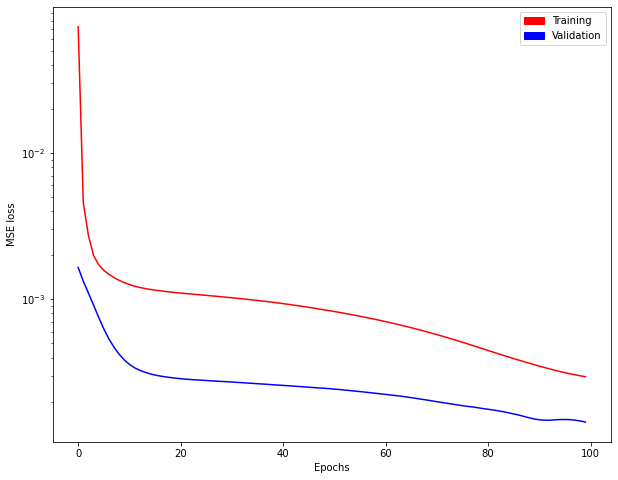

In [ ]:
plt.figure(figsize=(10,8))
plotting(history) # Evolution of training/test loss
multi_resdense_model.summary()
plt.savefig('0.001s20knewageresdense1-1batch32allep100lrelu10diff1u1500.png')

In [ ]:
multi_resdense_model.save_weights('./checkpoints/0.001s20knewageresdense1-1batch32allep100lrelu10diff1u1500')
history10= history.history['loss']
history10val= history.history['val_loss']
time10= elapsed

In [ ]:
multi_resdense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
  tf.keras.layers.Dense(20,
                    activation=partial(tf.nn.leaky_relu, alpha=0.5)),
    tf.keras.layers.Dense(OUT_STEPS*num_label,
                         kernel_initializer=tf.initializers.zeros
                         ),
])
compile(multi_resdense_model,lr=0.001)
tf.keras.backend.clear_session()
start_time = timeit.default_timer()
history = fit(multi_resdense_model, multi_window)

elapsed = timeit.default_timer() - start_time 
print(elapsed / 200)

Epoch 1/100
625/625 [==============================] - 2s 3ms/step - loss: 0.0333 - mean_squared_error: 0.0333 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 2/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 3/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 7.9099e-04 - val_mean_squared_error: 7.9099e-04
Epoch 4/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 5.1628e-04 - val_mean_squared_error: 5.1628e-04
Epoch 5/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 4.4968e-04 - val_mean_squared_error: 4.4968e-04
Epoch 6/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 4.2763e-04 - val_mean_squared_error: 4

625/625 [==============================] - 1s 2ms/step - loss: 3.4689e-04 - mean_squared_error: 3.4689e-04 - val_loss: 1.7914e-04 - val_mean_squared_error: 1.7914e-04
Epoch 94/100
625/625 [==============================] - 1s 2ms/step - loss: 3.4166e-04 - mean_squared_error: 3.4166e-04 - val_loss: 1.7578e-04 - val_mean_squared_error: 1.7578e-04
Epoch 95/100
625/625 [==============================] - 1s 2ms/step - loss: 3.3701e-04 - mean_squared_error: 3.3701e-04 - val_loss: 1.7254e-04 - val_mean_squared_error: 1.7254e-04
Epoch 96/100
625/625 [==============================] - 1s 2ms/step - loss: 3.3279e-04 - mean_squared_error: 3.3279e-04 - val_loss: 1.6911e-04 - val_mean_squared_error: 1.6911e-04
Epoch 97/100
625/625 [==============================] - 1s 1ms/step - loss: 3.2897e-04 - mean_squared_error: 3.2897e-04 - val_loss: 1.6655e-04 - val_mean_squared_error: 1.6655e-04
Epoch 98/100
625/625 [==============================] - 1s 2ms/step - loss: 3.2524e-04 - mean_squared_error: 3.25

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1, 9)              0         
_________________________________________________________________
dense (Dense)                (None, 1, 20)             200       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 2)              42        
Total params: 242
Trainable params: 242
Non-trainable params: 0
_________________________________________________________________


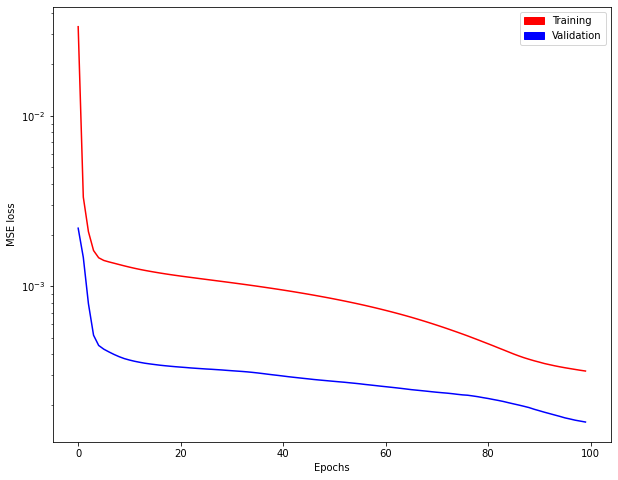

In [ ]:
plt.figure(figsize=(10,8))
plotting(history) # Evolution of training/test loss
multi_resdense_model.summary()
plt.savefig('0.001s20knewageresdense1-1batch32allep100lrelu20diff1u1500.png')

In [ ]:
multi_resdense_model.save_weights('./checkpoints/0.001s20knewageresdense1-1batch32allep100lrelu20diff1u1500')
history20= history.history['loss']
history20val= history.history['val_loss']
time20=elapsed

In [ ]:
multi_resdense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
  tf.keras.layers.Dense(30, activation=partial(tf.nn.leaky_relu, alpha=0.5)),
    tf.keras.layers.Dense(OUT_STEPS*num_label,
                         kernel_initializer=tf.initializers.zeros
                         ),
])
compile(multi_resdense_model,lr=0.001)
tf.keras.backend.clear_session()
start_time = timeit.default_timer()
history = fit(multi_resdense_model, multi_window)

elapsed = timeit.default_timer() - start_time 
print(elapsed / 200)

Epoch 1/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 2/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 5.8215e-04 - val_mean_squared_error: 5.8215e-04
Epoch 3/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 4.4757e-04 - val_mean_squared_error: 4.4757e-04
Epoch 4/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 4.1542e-04 - val_mean_squared_error: 4.1542e-04
Epoch 5/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 3.9932e-04 - val_mean_squared_error: 3.9932e-04
Epoch 6/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 3.8711e-04 - val_mean_squared_

Epoch 48/100
625/625 [==============================] - 1s 2ms/step - loss: 6.0677e-04 - mean_squared_error: 6.0677e-04 - val_loss: 2.7864e-04 - val_mean_squared_error: 2.7864e-04
Epoch 49/100
625/625 [==============================] - 1s 2ms/step - loss: 5.8806e-04 - mean_squared_error: 5.8806e-04 - val_loss: 2.7882e-04 - val_mean_squared_error: 2.7882e-04
Epoch 50/100
625/625 [==============================] - 1s 2ms/step - loss: 5.7211e-04 - mean_squared_error: 5.7211e-04 - val_loss: 2.8022e-04 - val_mean_squared_error: 2.8022e-04
Epoch 51/100
625/625 [==============================] - 1s 2ms/step - loss: 5.5744e-04 - mean_squared_error: 5.5744e-04 - val_loss: 2.8041e-04 - val_mean_squared_error: 2.8041e-04
Epoch 52/100
625/625 [==============================] - 1s 2ms/step - loss: 5.4427e-04 - mean_squared_error: 5.4427e-04 - val_loss: 2.7987e-04 - val_mean_squared_error: 2.7987e-04
Epoch 53/100
625/625 [==============================] - 1s 2ms/step - loss: 5.3246e-04 - mean_square

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1, 9)              0         
_________________________________________________________________
dense (Dense)                (None, 1, 30)             300       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 2)              62        
Total params: 362
Trainable params: 362
Non-trainable params: 0
_________________________________________________________________


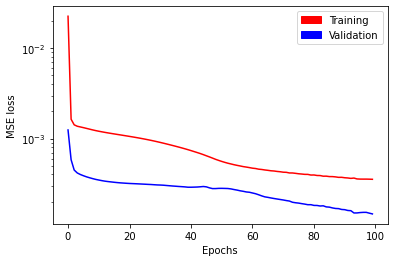

In [ ]:
plotting(history) 
multi_resdense_model.summary()
plt.savefig('0.001s20knewageresdense1-1batch32allep100lrelu30diff1u1500.png')

In [ ]:
multi_resdense_model.save_weights('./checkpoints/0.001s20knewageresdense1-1batch32allep100lrelu30diff1u1500')
history30= history.history['loss']
history30val= history.history['val_loss']
time30=elapsed

In [ ]:
multi_resdense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
  tf.keras.layers.Dense(40, activation=partial(tf.nn.leaky_relu, alpha=0.5)),
    tf.keras.layers.Dense(OUT_STEPS*num_label,
                         kernel_initializer=tf.initializers.zeros
                         ),
])
compile(multi_resdense_model,lr=0.0003)
tf.keras.backend.clear_session()
start_time = timeit.default_timer()
history = fit(multi_resdense_model, multi_window)

elapsed = timeit.default_timer() - start_time 
print(elapsed / 200)

Epoch 1/100
625/625 [==============================] - 1s 2ms/step - loss: 0.1014 - mean_squared_error: 0.1014 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 2/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 8.7858e-04 - val_mean_squared_error: 8.7858e-04
Epoch 4/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 6.6228e-04 - val_mean_squared_error: 6.6228e-04
Epoch 5/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 5.3232e-04 - val_mean_squared_error: 5.3232e-04
Epoch 6/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 4.5674e-04 - val_mean_squared_error: 4

625/625 [==============================] - 1s 2ms/step - loss: 6.6567e-04 - mean_squared_error: 6.6567e-04 - val_loss: 2.8992e-04 - val_mean_squared_error: 2.8992e-04
Epoch 94/100
625/625 [==============================] - 1s 2ms/step - loss: 6.5914e-04 - mean_squared_error: 6.5914e-04 - val_loss: 2.8880e-04 - val_mean_squared_error: 2.8880e-04
Epoch 95/100
625/625 [==============================] - 1s 2ms/step - loss: 6.5261e-04 - mean_squared_error: 6.5261e-04 - val_loss: 2.8768e-04 - val_mean_squared_error: 2.8768e-04
Epoch 96/100
625/625 [==============================] - 1s 2ms/step - loss: 6.4607e-04 - mean_squared_error: 6.4607e-04 - val_loss: 2.8661e-04 - val_mean_squared_error: 2.8661e-04
Epoch 97/100
625/625 [==============================] - 1s 2ms/step - loss: 6.3953e-04 - mean_squared_error: 6.3953e-04 - val_loss: 2.8554e-04 - val_mean_squared_error: 2.8554e-04
Epoch 98/100
625/625 [==============================] - 1s 2ms/step - loss: 6.3301e-04 - mean_squared_error: 6.33

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1, 9)              0         
_________________________________________________________________
dense (Dense)                (None, 1, 40)             400       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 2)              82        
Total params: 482
Trainable params: 482
Non-trainable params: 0
_________________________________________________________________


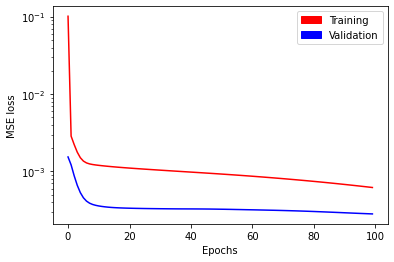

In [ ]:
plotting(history) 
multi_resdense_model.summary()
plt.savefig('0.001s20knewageresdense1-1batch32allep100lrelu40diff2u1500.png')

In [ ]:
multi_resdense_model.save_weights('./checkpoints/0.001s20knewageresdense1-1batch32allep100lrelu40diff2u1500')
history40= history.history['loss']
history40val= history.history['val_loss']
time40=elapsed

In [ ]:
multi_resdense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
  tf.keras.layers.Dense(50, activation=partial(tf.nn.leaky_relu, alpha=0.5)),

    tf.keras.layers.Dense(OUT_STEPS*num_label,
                         kernel_initializer=tf.initializers.zeros
                         ),
])
compile(multi_resdense_model,lr=0.001)
tf.keras.backend.clear_session()
start_time = timeit.default_timer()
history = fit(multi_resdense_model, multi_window)

elapsed = timeit.default_timer() - start_time 
print(elapsed / 200)

Epoch 1/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 6.7345e-04 - val_mean_squared_error: 6.7345e-04
Epoch 2/100
625/625 [==============================] - 1s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 4.7651e-04 - val_mean_squared_error: 4.7651e-04
Epoch 3/100
625/625 [==============================] - 1s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 4.2857e-04 - val_mean_squared_error: 4.2857e-04
Epoch 4/100
625/625 [==============================] - 1s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 4.0407e-04 - val_mean_squared_error: 4.0407e-04
Epoch 5/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 3.8731e-04 - val_mean_squared_error: 3.8731e-04
Epoch 6/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 3.7483e-04 - val_mean_

625/625 [==============================] - 1s 2ms/step - loss: 4.3048e-04 - mean_squared_error: 4.3048e-04 - val_loss: 2.0371e-04 - val_mean_squared_error: 2.0371e-04
Epoch 93/100
625/625 [==============================] - 1s 2ms/step - loss: 3.3170e-04 - mean_squared_error: 3.3170e-04 - val_loss: 1.9976e-04 - val_mean_squared_error: 1.9976e-04
Epoch 94/100
625/625 [==============================] - 1s 2ms/step - loss: 4.4538e-04 - mean_squared_error: 4.4538e-04 - val_loss: 2.1349e-04 - val_mean_squared_error: 2.1349e-04
Epoch 95/100
625/625 [==============================] - 1s 2ms/step - loss: 3.2374e-04 - mean_squared_error: 3.2374e-04 - val_loss: 4.0337e-04 - val_mean_squared_error: 4.0337e-04
Epoch 96/100
625/625 [==============================] - 1s 2ms/step - loss: 5.0664e-04 - mean_squared_error: 5.0664e-04 - val_loss: 2.4350e-04 - val_mean_squared_error: 2.4350e-04
Epoch 97/100
625/625 [==============================] - 1s 2ms/step - loss: 3.4568e-04 - mean_squared_error: 3.45

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_12 (Lambda)           (None, 1, 9)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1, 50)             500       
_________________________________________________________________
dense_25 (Dense)             (None, 1, 2)              102       
Total params: 602
Trainable params: 602
Non-trainable params: 0
_________________________________________________________________


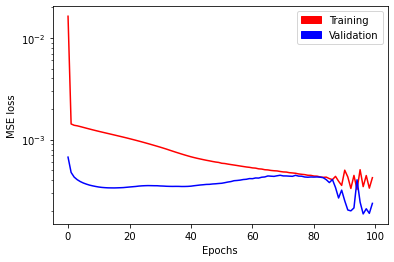

In [ ]:
plotting(history) 
multi_resdense_model.summary()
plt.savefig('0.001s20knewageresdense1-1batch32allep100lrelu50diff2u1500.png')

In [ ]:
multi_resdense_model.save_weights('./checkpoints/0.001s20knewageresdense1-1batch32allep100lrelu50diff2u1500')
history50= history.history['loss']
history50val= history.history['val_loss']
time50=elapsed

In [ ]:
history20ku2000= np.array(([history10,history20,history30,history40,history50]))
history20ku2000VAL= np.array(([history10val,history20val,history30val,history40val,history50val]))
ttime= np.array(([time10,time20,time30,time40,time50]))


In [ ]:
ttime

array([109.52859202, 127.10089464, 124.10861165, 111.15990775,
       109.29263531])

In [ ]:
aa=pd.DataFrame(history20ku2000)
aa.to_csv('history20ku1500.csv',index=False)

In [ ]:
aaval=pd.DataFrame(history20ku2000VAL)
aaval.to_csv('history20ku1500VAL.csv',index=False)

## TEST NN MODEL

In [ ]:
xmean=train_mean[{'x1','x3'}]
xmean=xmean[['x1','x3']]
diffmean=train_mean[{'diff1','diff3'}]
diffmean=diffmean[['diff1','diff3']]
xstd=train_std[{'x1','x3'}]
xstd=xstd[['x1','x3']]
diffstd=train_std[{'diff1','diff3'}]
diffstd=diffstd[['diff1','diff3']]

def standardize(modelinput):
    modelinput = (modelinput -train_mean.values) / train_std.values
    return modelinput

def destandardize(modeloutput):
    modeloutput = (modeloutput * train_std.values) + train_mean.values
    return modeloutput

def denormalize(outputs):
    outputs = outputs * diffstd + diffmean
    return outputs

In [ ]:
OUT_STEPS=1
num_label=2
hiddennodes=50

In [ ]:
multi_resdense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
  tf.keras.layers.Dense(hiddennodes, activation=partial(tf.nn.leaky_relu, alpha=0.5)),
    tf.keras.layers.Dense(OUT_STEPS*num_label,
                         kernel_initializer=tf.initializers.zeros
                         ),
])

## Load NN Model and random testing

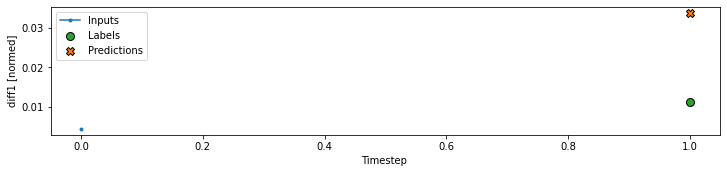

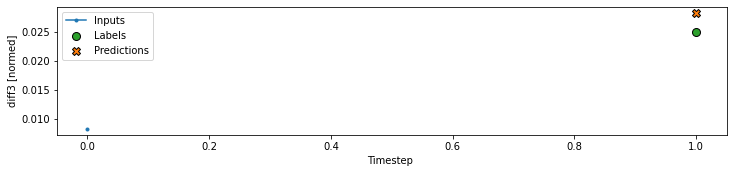

In [ ]:

multi_resdense_model.load_weights('./checkpoints/0.001s20knewageresdense1-1batch32allep100lrelu50diff2u1500')
multi_window.plot('diff1',model=multi_resdense_model)
multi_window.plot('diff3',model=multi_resdense_model)

In [ ]:
#test data
testdata= pd.read_csv('u1000testdata5k_0.001ssim.csv')
#validation data
testdata= pd.read_csv('u1000validationdatanewage5k_0.001ssim.csv')
#training data
#testdata= df[:5001]

In [ ]:
saveerrordiff=np.zeros((5000-1,2))
saveerrorstate=np.zeros((5000-1,2))
start_time = timeit.default_timer()
for i in range(5000-1):
    NNinput= standardize(testdata[i:i+1].values)
    curr=testdata.iloc[i:i+1,3:5].values
    grounddiff=  testdata.iloc[i+1:i+2,-2:].values
    groundstate= testdata.iloc[i+1:i+2,3:5].values
    prednorm=denormalize(multi_resdense_model(np.array([NNinput])))
    predstate= curr + prednorm
    errordiff= prednorm - grounddiff
    errorstate= predstate - groundstate
    saveerrordiff[i]= errordiff
    saveerrorstate[i]= errorstate
elapsed = timeit.default_timer() - start_time 
print("elapsed time: ", elapsed)
np.square(saveerrorstate).mean()

elapsed time:  11.939257156000053


1.1010818113725072e-06

In [ ]:
testdata[1:3]

,u1,dist.,u2,x1,x3,diff21,diff23,diff1,diff3
1,841.748776,134.538286,-1288.767215,0.001744,0.000662,0.001396,0.000670,0.000599,0.000342
2,-6.377166,-398.773768,884.911895,0.002464,0.000026,0.001318,-0.000294,0.000720,-0.000636


In [ ]:
NNinput= standardize(testdata[1:2].values)
prednorm=denormalize(multi_resdense_model(np.array([NNinput])))
prednorm

<tf.Tensor: shape=(1, 1, 2), dtype=float64, numpy=array([[[ 0.00164041, -0.00032798]]])>

## Evaluate 10-Step Ahead Prediction

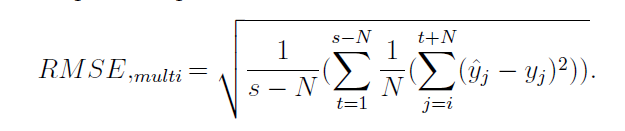


In [ ]:
horizon=10
NUMDATA=4990
saveerrordiff=np.zeros((NUMDATA,2))
saveerrorstate=np.zeros((NUMDATA,2))
temp= np.zeros((1,9))
start_time = timeit.default_timer()

for i in range(NUMDATA):
    prednormm= np.zeros((horizon,2))
    predstatee= np.zeros((horizon,2))
    grounddiff=  testdata.iloc[i+1:i+11,-2:].values
    groundstate= testdata.iloc[i+1:i+11,3:5].values
    NNinput= (testdata[i:i+11].values)
    temp= np.array([NNinput[0]])
    allee=np.vstack((temp[-1:]))
    actions= NNinput[:,0:3]
    curr=testdata.iloc[i:i+1,3:5].values
    for j in range(10):
        #set actions
        prednorm=denormalize(multi_resdense_model(np.array([standardize(temp)])))
        predstate= curr + prednorm
        temp[-1,0:3] = actions[j+1,:]
        temp[-1,3:5] = predstate
        temp[-1, 5:7] = temp[-1,-2:] + prednorm
        temp[-1, -2:] = prednorm
        curr=predstate
        prednormm[j,:]=prednorm
        predstatee[j,:]=predstate
        allee= np.vstack((allee,temp[-1:]))
    errordiff= np.square(prednormm - grounddiff).mean()
    errorstate= np.square(predstatee - groundstate).mean()
    saveerrordiff[i]= errordiff
    saveerrorstate[i]= errorstate
    
   
elapsed = timeit.default_timer() - start_time 
print("elapsed time: ", elapsed)
saveerrorstate.mean()

elapsed time:  92.11942693900005


0.0018512989849595557

In [ ]:
saveerrorstate

array([[1.73265897e-04, 1.73265897e-04],
       [1.38439869e-04, 1.38439869e-04],
       [8.12760955e-05, 8.12760955e-05],
       ...,
       [2.65207211e-03, 2.65207211e-03],
       [2.38894798e-03, 2.38894798e-03],
       [1.88965780e-03, 1.88965780e-03]])

In [ ]:
saveerrorstate[4550:4600]

array([[1.69676242e-04, 1.69676242e-04],
       [2.97358316e-04, 2.97358316e-04],
       [3.17845501e-04, 3.17845501e-04],
       [3.26184180e-04, 3.26184180e-04],
       [3.18771874e-04, 3.18771874e-04],
       [3.07287115e-04, 3.07287115e-04],
       [2.73086680e-04, 2.73086680e-04],
       [1.53031927e-04, 1.53031927e-04],
       [1.68135689e-04, 1.68135689e-04],
       [7.57451170e-05, 7.57451170e-05],
       [6.58026352e-05, 6.58026352e-05],
       [4.29178932e-05, 4.29178932e-05],
       [7.10660099e-05, 7.10660099e-05],
       [1.34872077e-04, 1.34872077e-04],
       [1.74712477e-05, 1.74712477e-05],
       [1.66825945e-04, 1.66825945e-04],
       [1.68567796e-05, 1.68567796e-05],
       [2.48526459e-05, 2.48526459e-05],
       [3.81289593e-05, 3.81289593e-05],
       [2.91780203e-05, 2.91780203e-05],
       [6.80352301e-05, 6.80352301e-05],
       [1.44665624e-04, 1.44665624e-04],
       [8.02159955e-05, 8.02159955e-05],
       [6.18522864e-05, 6.18522864e-05],
       [5.036341

In [ ]:
errorstate

0.0018896578037094834

In [ ]:
predstatee - groundstate

array([[-0.00068196,  0.00122894],
       [-0.0009167 ,  0.00423429],
       [-0.00063476,  0.00969763],
       [ 0.00019306,  0.01774679],
       [ 0.00240756,  0.02781817],
       [ 0.00635771,  0.04069439],
       [ 0.01116414,  0.05646515],
       [ 0.01723356,  0.0753246 ],
       [ 0.02489444,  0.09682825],
       [ 0.03274622,  0.12056275]])

In [ ]:
prednormm

array([[ 0.03260404, -0.03448707],
       [ 0.03396285, -0.03335363],
       [ 0.03574099, -0.03172656],
       [ 0.03688576, -0.02880807],
       [ 0.03783108, -0.02612344],
       [ 0.03977631, -0.02296941],
       [ 0.04123013, -0.02006061],
       [ 0.04162561, -0.01729712],
       [ 0.04287022, -0.01449692],
       [ 0.04273861, -0.01152589]])

In [ ]:
grounddiff

array([[ 0.033286  , -0.03571601],
       [ 0.03419759, -0.03635898],
       [ 0.03545905, -0.0371899 ],
       [ 0.03605794, -0.03685724],
       [ 0.03561657, -0.03619482],
       [ 0.03582615, -0.03584563],
       [ 0.0364237 , -0.03583137],
       [ 0.0355562 , -0.03615656],
       [ 0.03520934, -0.03600058],
       [ 0.03488683, -0.03526039]])

In [ ]:
prednormm - grounddiff

array([[-0.00068196,  0.00122894],
       [-0.00023474,  0.00300535],
       [ 0.00028194,  0.00546333],
       [ 0.00082782,  0.00804916],
       [ 0.0022145 ,  0.01007138],
       [ 0.00395015,  0.01287622],
       [ 0.00480643,  0.01577076],
       [ 0.00606942,  0.01885945],
       [ 0.00766088,  0.02150365],
       [ 0.00785178,  0.0237345 ]])

In [ ]:
testdata.iloc[:11,-2:].values

array([[ 7.97210279e-04,  3.28480809e-04],
       [ 5.98732844e-04,  3.41840247e-04],
       [ 7.19678034e-04, -6.35518447e-04],
       [ 1.13491225e-03, -8.37737309e-04],
       [ 5.56623311e-04,  3.08110140e-04],
       [-1.86374786e-04,  4.65550091e-04],
       [-5.15989630e-04, -4.13335158e-05],
       [-9.21979274e-04, -1.15106727e-04],
       [-1.79555961e-03,  4.13703054e-04],
       [-2.62646859e-03,  9.89150280e-04],
       [-2.96618572e-03,  1.59004915e-03]])

In [ ]:
mypred=pd.DataFrame(allee[:],columns =["u1","dist.","u2","x1","x3","diff21","diff23","diff1","diff3"])
mypred

,u1,dist.,u2,x1,x3,diff21,diff23,diff1,diff3
0,51.995138,240.587160,-783.892155,-1.002091,-2.403271,0.063360,-0.070438,0.032188,-0.035453
1,1233.568046,-266.517610,-1478.650653,-0.969811,-2.438437,0.064469,-0.070619,0.032281,-0.035166
2,864.384375,459.546220,-1187.755777,-0.936592,-2.473943,0.065499,-0.070672,0.033218,-0.035506
3,26.744113,396.472487,816.583880,-0.902947,-2.509198,0.066864,-0.070761,0.033646,-0.035255
4,-1096.949926,249.195750,-553.381026,-0.869628,-2.542885,0.066965,-0.068942,0.033319,-0.033687
5,1443.433760,-233.023002,158.403518,-0.836735,-2.575509,0.066212,-0.066311,0.032893,-0.032624
6,-192.886946,-273.964256,-1250.337524,-0.803108,-2.607187,0.066520,-0.064302,0.033627,-0.031678
7,-1362.213941,-2.212844,-551.454087,-0.769156,-2.638273,0.067578,-0.062764,0.033951,-0.031086
8,971.575816,-442.385796,-316.785438,-0.736007,-2.668420,0.067101,-0.061233,0.033150,-0.030147
9,-1179.426227,-17.383337,587.103913,-0.702523,-2.697953,0.066634,-0.059679,0.033484,-0.029533


In [ ]:
testdata[4989:5000]

,u1,dist.,u2,x1,x3,diff21,diff23,diff1,diff3
4989,51.995138,240.587160,-783.892155,-1.002091,-2.403271,0.063360,-0.070438,0.032188,-0.035453
4990,1233.568046,-266.517610,-1478.650653,-0.968805,-2.438987,0.065474,-0.071169,0.033286,-0.035716
4991,864.384375,459.546220,-1187.755777,-0.934608,-2.475346,0.067484,-0.072075,0.034198,-0.036359
4992,26.744113,396.472487,816.583880,-0.899149,-2.512536,0.069657,-0.073549,0.035459,-0.037190
4993,-1096.949926,249.195750,-553.381026,-0.863091,-2.549393,0.071517,-0.074047,0.036058,-0.036857
4994,1443.433760,-233.023002,158.403518,-0.827474,-2.585588,0.071675,-0.073052,0.035617,-0.036195
4995,-192.886946,-273.964256,-1250.337524,-0.791648,-2.621433,0.071443,-0.072040,0.035826,-0.035846
4996,-1362.213941,-2.212844,-551.454087,-0.755224,-2.657265,0.072250,-0.071677,0.036424,-0.035831
4997,971.575816,-442.385796,-316.785438,-0.719668,-2.693421,0.071980,-0.071988,0.035556,-0.036157
4998,-1179.426227,-17.383337,587.103913,-0.684459,-2.729422,0.070766,-0.072157,0.035209,-0.036001


In [ ]:
beda=testdata.iloc[4990:5000,3:5].values-mypred.iloc[1:,3:5]
beda

,x1,x3
1,0.001005,-0.000550
2,0.001985,-0.001403
3,0.003798,-0.003338
4,0.006537,-0.006508
5,0.009261,-0.010079
6,0.011460,-0.014246
7,0.013932,-0.018992
8,0.016339,-0.025001
9,0.018064,-0.031469
10,0.020381,-0.038890


In [ ]:
np.square(beda.values).mean()

0.0002665383651134016

In [ ]:
beda2= testdata.iloc[999:1009,-2:].values-mypred.iloc[1:,-2:]
beda2

,diff1,diff3
1,-0.016224,0.016592
2,-0.017819,0.016474
3,-0.019104,0.015644
4,-0.019256,0.014009
5,-0.019634,0.014232
6,-0.021769,0.013656
7,-0.023265,0.012070
8,-0.022428,0.010840
9,-0.022308,0.010966
10,-0.020997,0.010296


In [ ]:
np.square(beda2.values).mean()

0.00030124198689559855